# PART 1 - EXPLORATORY DATA ANALYSIS

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import date
from dateutil.relativedelta import relativedelta

# Read in logins JSON data and load into pandas DataFrame

logins_df = pd.read_json('logins.json')

# Make login_time the index and sort by index

logins_df.index = logins_df['login_time']

logins_df = logins_df.sort_index()

logins_df.head()

,login_time
login_time,
1970-01-01 20:12:16,1970-01-01 20:12:16
1970-01-01 20:13:18,1970-01-01 20:13:18
1970-01-01 20:16:10,1970-01-01 20:16:10
1970-01-01 20:16:36,1970-01-01 20:16:36
1970-01-01 20:16:37,1970-01-01 20:16:37


In [33]:
# Aggregate counts of logins in 15-minute intervals

fifteen_min_counts = logins_df['login_time'].resample('15Min').count()

fifteen_min_counts.head()

login_time
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
Freq: 15T, Name: login_time, dtype: int64

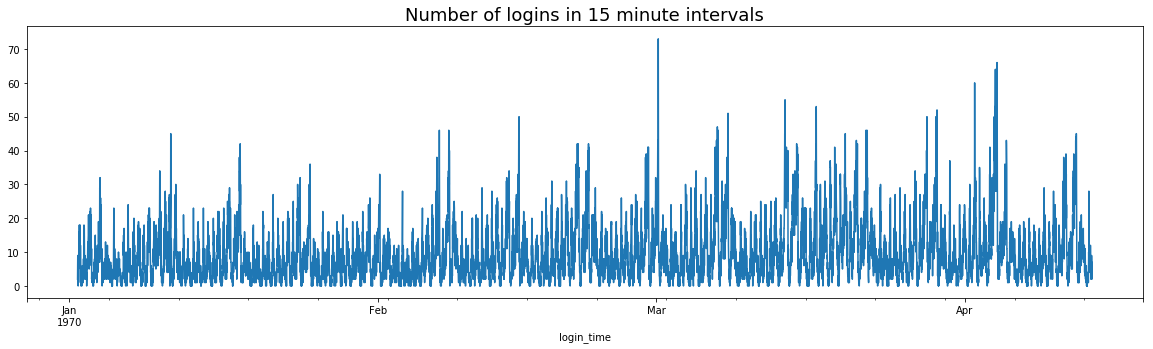

In [34]:
# Plot the 15-minute counts data

plt.figure(figsize=(20,5))

plt.title('Number of logins in 15 minute intervals', fontsize=18)

fifteen_min_counts.plot()

+ It is difficult to tell from this plot the nature of the daily cycles. We will look at some examples of daily 15-minute counts.

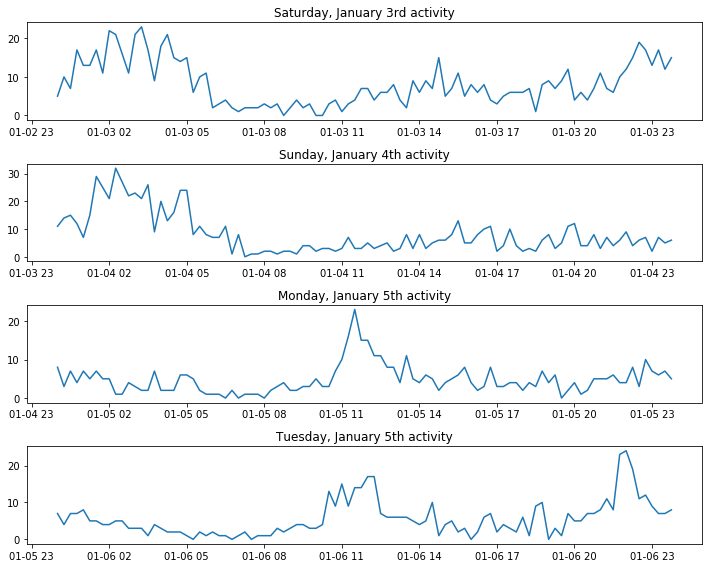

In [4]:
fig, axes = plt.subplots(4,1,figsize=(10,8))

axes[0].plot(fifteen_min_counts.loc['1970-01-03'])
axes[0].set_title('Saturday, January 3rd activity')

axes[1].plot(fifteen_min_counts.loc['1970-01-04'])
axes[1].set_title('Sunday, January 4th activity')

axes[2].plot(fifteen_min_counts.loc['1970-01-05'])
axes[2].set_title('Monday, January 5th activity')

axes[3].plot(fifteen_min_counts.loc['1970-01-06'])
axes[3].set_title('Tuesday, January 5th activity')

plt.tight_layout()
plt.show()

+ The first two plots show login activity for a weekend (Saturday and Sunday) in January. From these, we can see that the largest volume of activity occurs during the early part of the morning, between midnight and 5 AM. We might suspect that late-night party-goers are beginning to end their night-out from the night before around this time. This would explain the spike on Saturday, January 3rd (first plot) around 11 PM.
+ The second two plots show login activity for two weekdays in January (Monday and Tuesday). These two plots show an uptake in activity around mid day, between 10 AM and 2 PM. This might indicate lunch time for the average worker.

# PART 2 - EXPERIMENT AND METRICS DESIGN

### What metric will we use?

+ The experiment's success can be measured by the average proportion of each driver's trips that originate in his/her home city (Metropolis or Gotham). Before the experiment, we expect that each driver's proportion will be extremely high, due to the desire to avoid tolls. If the experiment is successful, we expect that each driver will service not only his/her home city, but both cities. This should result in a decrease in the average proportion described above.

### The experiment

+ We will need the data described above for both pre-toll-reimbursement, and post-toll-reimbursement. Ideally, this would include data for equal time periods before and after the toll-reimbursement
+ Given two arrays, with the proportions of each driver's trips originating in his/her home city before, and after the toll-reimbursement, we can perform a permutation hypothesis test on the difference in means. We would combine the two arrays, permute the array, and then split the permuted array into two new test arrays. We then compute the difference in means between the two arrays. We would repeat this process of generating permutation replicates a sufficient number of times, say 10,000. We compute the p-value by determining what proportion of these permutation replicates are greater than the actual observed difference in proportions before and after the toll-reimbursement was implemented. If the p-value is sufficiently small, we can conclude that the experiment was successful, and that now, on average, each driver makes fewer trips to his/her own city, and more to the other city.
+ If the p-value is sufficiently small, there are few recommendations necessary. The experiment was successful. However, perhaps the same result could have been acheived in a more cost-effective manner. For example, are there other incentives for drivers to make trips to the opposite city? Do we need to reimburse ALL of the toll costs, or just most of them?
+ If the p-value is small, but perhaps not statistically significant (greater than 0.05, for example), we might recommend to city operations further incentives to increase driver availability in both cities. Perhaps we can weigh the projected profit increase from serving more people in both cities to say, the cost of a potential pay increase for drivers that service both cities.

# PART 3 - PREDICTIVE MODELING

+ To deal with possible null values, we will read in the ultimate_data JSON as a string and load it using json.loads. Then we will create a pandas DataFrame from the data and inspect the state of the data.

In [5]:
# Read in ultimate_data JSON as a string, load it, and create pandas DataFrame

file = open('ultimate_data_challenge.json', 'r')

file_content=file.read()

file.close()

data=json.loads(file_content)

ultimate_df=pd.DataFrame(data)

ultimate_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [6]:
ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


+ We see three key problems in the data so far. First, the two date columns, "last_trip_date" and "signup_date," are objects. We will convert them to datetime objects for easier manipulation.

In [7]:
# Convert last_trip_date and _signup_date columns to Datetime objects

ultimate_df['signup_date'] = pd.to_datetime(ultimate_df['signup_date'])
ultimate_df['last_trip_date'] = pd.to_datetime(ultimate_df['last_trip_date'])

ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


+ Second, the ultimate_black_user column is boolean, but for our model, we will need to convert it to integer.

In [8]:
ultimate_df['ultimate_black_user'] = ultimate_df['ultimate_black_user'].astype(int)

+ Third, there are three columns with null entries. Based on the histograms below, we see that the distributions for the avg_rating columns are heavily skewed, so we will impute missing values with their medians. The "phone" column is an object, so will impute its missing values with the mode.

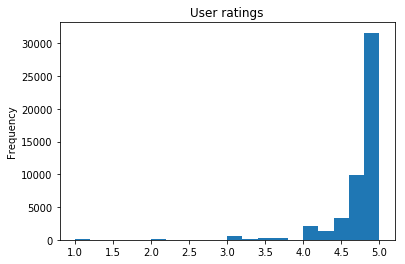

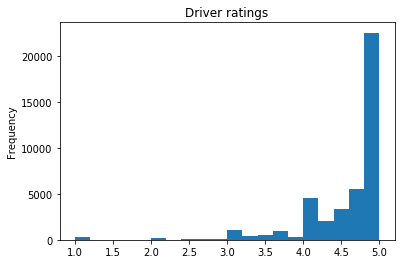

In [9]:
# Examine the distributions of driver/user ratings

ultimate_df['avg_rating_by_driver'].plot(kind='hist', bins=20)
plt.title('User ratings')
plt.show()

ultimate_df['avg_rating_of_driver'].plot(kind='hist', bins=20)
plt.title('Driver ratings')
plt.show()

In [10]:
# Impute the avg_rating columns with their respective medians.

ultimate_df['avg_rating_by_driver'] = ultimate_df['avg_rating_by_driver'].fillna(ultimate_df['avg_rating_by_driver'].median())
ultimate_df['avg_rating_of_driver'] = ultimate_df['avg_rating_of_driver'].fillna(ultimate_df['avg_rating_of_driver'].median())

# Impute the phone column with its mode.

ultimate_df['phone'] = ultimate_df['phone'].fillna(ultimate_df['phone'].mode()[0])

ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null int32
weekday_pct               50000 non-null float64
dtypes: datetime64[ns](2), float64(6), int32(1), int64(1), object(2)
memory usage: 4.4+ MB


+ We are attempting to predict whether a user will still be active in their 6th month. To do this, we need a column denoting the date five months after each user signs up, and then we need to determine if that user has made a trip within 30 days prior to that date.

In [11]:
# Create column denoting the date 5 months after each user signs up.

def add_five_months(row):
    
    return row + relativedelta(months=5)

ultimate_df['five_months_after_signup'] = ultimate_df['signup_date'].apply(add_five_months)

ultimate_df[['signup_date','five_months_after_signup']].head()

,signup_date,five_months_after_signup
0,2014-01-25,2014-06-25
1,2014-01-29,2014-06-29
2,2014-01-06,2014-06-06
3,2014-01-10,2014-06-10
4,2014-01-27,2014-06-27


+ If the difference in days between five_months_after_signup and last_trip_date is less than or equal to 30, the user was still active in the beginnign of his/her 6th month. Note that if this difference is negative, then the user's last trip was after the five_months_after_signup date, and so the user is still considered active.

In [12]:
# Create a column denoting whether a user is active in his/her 6th month. 
# Once this is done, remove the date columns from the DataFrame


def determine_status(last_trip, five_months_after):
    
    if (five_months_after - last_trip).days <=30:
        return 'active'
    else:
        return 'inactive'
    
ultimate_df['status'] = ultimate_df.apply(lambda x: determine_status(x['last_trip_date'], x['five_months_after_signup']), axis=1)

ultimate_df.drop(['signup_date','five_months_after_signup', 'last_trip_date'], axis=1, inplace=True)



+ The final step in our preprocessing is to one-hot-encode the categorical features, phone and city.

In [13]:
# Get dummy variables for the phone, city, and ultimate_black_user columns, 
# and drop the original columns from the DataFrame.

phone_dummies = pd.get_dummies(ultimate_df['phone'], prefix='phone')
city_dummies = pd.get_dummies(ultimate_df['city'], prefix='city')

ultimate_df = pd.concat([ultimate_df, phone_dummies], axis=1)
ultimate_df = pd.concat([ultimate_df, city_dummies], axis=1)

ultimate_df.drop(['city', 'phone'], axis=1, inplace=True)

ultimate_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,status,phone_Android,phone_iPhone,city_Astapor,city_King's Landing,city_Winterfell
0,3.67,5.0,4.7,1.10,15.4,4,1,46.2,active,0,1,0,1,0
1,8.26,5.0,5.0,1.00,0.0,0,0,50.0,inactive,1,0,1,0,0
2,0.77,5.0,4.3,1.00,0.0,3,0,100.0,inactive,0,1,1,0,0
3,2.36,4.9,4.6,1.14,20.0,9,1,80.0,active,0,1,0,1,0
4,3.13,4.9,4.4,1.19,11.8,14,0,82.4,inactive,1,0,0,0,1


In [14]:
ultimate_df['status'].value_counts()

inactive    27488
active      22512
Name: status, dtype: int64

+ We see that our target variable has a nearly equal number of active and inactive users, so no class balancing is necessary. Let's take one more look at our cleaned up data. 

In [15]:
ultimate_df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,phone_Android,phone_iPhone,city_Astapor,city_King's Landing,city_Winterfell
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.779050,4.650038,1.074764,8.849536,2.278200,0.37708,60.926084,0.300440,0.699560,0.330680,0.202600,0.466720
std,5.707357,0.445974,0.575601,0.222336,19.958811,3.792684,0.48466,37.081503,0.458454,0.458454,0.470463,0.401941,0.498896
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.500000,1.000000,0.000000,0.000000,0.00000,33.300000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,0.00000,66.700000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,1.00000,100.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,1.00000,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Fitting the models

+ I will be experimenting with three classifiers: random forest, logistic regression, and KNeighbors. I will analyze the accuracy score and classification report for each, and return the best model. This approach allows for greater flexibility in fitting the data to the best model.
+ I chose these models because they are relatively adept at handling a large number of rows with a relatively small number of features. I considered using a support vector classifier, but decided against this due to the amount of time that would be required to train the model.

In [16]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import numpy as np

In [17]:
# Create X and y, the feature space and target variable, respectively.
# X will contain the cleaned features above.
# y will denote whether or not the user is/was active in his/her 6th month after signing up, with a 1 corresponding to active.

X = ultimate_df.drop('status', axis=1).values
y = (ultimate_df['status'] == 'active').values

# Separate the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

+ I will be using grid search to tune the hyperparameters for each model. Once the GridSearch model is fit, I will use it to obtain the accuracy score and classification report.

In [18]:
### Random Forest Classifier

# Use GridSearchCV to tune the n_estimators (number of trees) parameter

num_trees = [10,50,100,200,500]
params = {'n_estimators': num_trees}

forest = RandomForestClassifier()

np.random.seed(42)

forest_cv = GridSearchCV(forest, params, cv=5)
forest_cv.fit(X_train,y_train)

forest_pred = forest_cv.predict(X_test)

# Print the accuracy score and classification report

print('The accuracy score on our test data is:', forest_cv.score(X_test, y_test))

print(classification_report(y_test, forest_pred))

print(forest_cv.best_params_)

The accuracy score on our test data is: 0.7304666666666667
             precision    recall  f1-score   support

      False       0.76      0.74      0.75      8288
       True       0.69      0.72      0.70      6712

avg / total       0.73      0.73      0.73     15000

{'n_estimators': 200}


In [19]:
### Logistic Regression

# Use GridSearch to tune the C and penalty parameters.

c_vals = np.logspace(-5,8,15)
penalty_vals = ['l1', 'l2']
params = {'C': c_vals, 'penalty': penalty_vals}

logreg = LogisticRegression()

np.random.seed(42)

logreg_cv = GridSearchCV(logreg, params, cv=5)
logreg_cv.fit(X_train, y_train)

log_pred = logreg_cv.predict(X_test)

# Print the accuracy score and classification report

print('The accuracy score on our test data is:', logreg_cv.score(X_test, y_test))

print(classification_report(y_test, log_pred))

print(logreg_cv.best_params_)

The accuracy score on our test data is: 0.6743333333333333
             precision    recall  f1-score   support

      False       0.68      0.79      0.73      8288
       True       0.67      0.54      0.60      6712

avg / total       0.67      0.67      0.67     15000

{'C': 0.006105402296585327, 'penalty': 'l2'}


In [23]:
### KNN

# Use GridSearch to tune the n_neighbors and p parameters

n_neighbors_vals = np.arange(3,30)
p_vals = [1,2]

params = {'n_neighbors': n_neighbors_vals, 'p': p_vals}

knn = KNeighborsClassifier()

np.random.seed(42)

knn_cv = GridSearchCV(knn, params, cv=5)
knn_cv.fit(X_train, y_train)

knn_pred = knn_cv.predict(X_test)

# Print the accuracy score and classification report

print('The accuracy score on our test data is:', knn_cv.score(X_test, y_test))

print(classification_report(y_test, knn_pred))

print(knn_cv.best_params_)

The accuracy score on our test data is: 0.7474666666666666
             precision    recall  f1-score   support

      False       0.76      0.80      0.78      8288
       True       0.73      0.68      0.71      6712

avg / total       0.75      0.75      0.75     15000

{'n_neighbors': 25, 'p': 1}


## Concerns about the data

+ First, the avg_dist column contains certain questionable entries, such as a minimum value of 0, and maximum value of 160. The 0 entries (there are only 150 of them) likely denote people who signed up for Ultimate but then never used the service for any trips. The 160 entry could be valid (although perhaps unlikely), but it is very unlikely this person took multiple trips that averaged that distance. Our models would likely perform better if we used data from people that took at least a certain number of trips.
+ Second, the avg_rating_of_driver and avg_rating_by_driver columns contain an overwhelming amount of 5.0 ratings. While this might be valid, these entries flood the data and might make it more difficult to predict the nature of rows with lower ratings.

## Analysis of models

+ We see that the KNN model with k=25 neighbors and L1 regularization performed the best, with an accuracy of almost 75%, and an average F1 score of 0.75 for the two classes.
+ We suspect it is possible that if we trained a different model, such as a Support Vector Classifier, then we might have acheived better results. But we chose these three models in the interest of time efficiency.
+ Based on the features that are most important to the model, we can recommend certain actions for the Ultimate operations team. For example, if retention seemed to be heavily influenced by the number of trips in the first 30 days, then we might recommend offering incentive discounts for user trips in the first 30 days after signup. If weekday_pct seems highly influential, then we might offer incentive discounts for users to make more or less trips during the weekends.